In [33]:
from sys import path

path.append('../')

import seaborn as sns
from pandas import DataFrame
from reservoirpy import verbosity
from reservoirpy.nodes import Reservoir, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error as mse

from mixed_ml import MixedMLEstimator
from training_utils.data import get_dataframe

verbosity(0)

0

In [2]:
data = get_dataframe("../../../data/synthetic_bph_1/01_test.csv")
SERIES = "individus"
TSTEPS = "temps"
#
data_train = data[data[SERIES] > 10]
data_test = data[data[SERIES] <= 10]

# Building the model 

Standard and recurrent models can be used

In [5]:
model_mlp = MLPRegressor((20, 10, 5), learning_rate='adaptive', max_iter=1000)
mixed_ml_mlp = MixedMLEstimator(model_mlp, recurrent_model=False)

In [6]:
model_rpy = Reservoir(units=50) >> Ridge(ridge=1e-3)
mixed_ml_rpy = MixedMLEstimator(model_rpy, recurrent_model=True)

# Training with simple features

x2_x5, x4_x7, x6_x8

In [24]:
X_LABELS = ["x2_x5", "x4_x7", "x6_x8"]
Y_LABEL = "y_mixed_obs"

scaler_x = RobustScaler()
scaler_y = RobustScaler()

data_train_scaled = data_train[[SERIES, TSTEPS]].copy()
data_train_scaled[X_LABELS] = scaler_x.fit_transform(data_train[X_LABELS])
data_train_scaled[[Y_LABEL]] = scaler_y.fit_transform(data_train[[Y_LABEL]])

data_test_scaled = data_test[[SERIES, TSTEPS]].copy()
data_test_scaled[X_LABELS] = scaler_x.transform(data_test[X_LABELS])
data_test_scaled[[Y_LABEL]] = scaler_y.transform(data_test[[Y_LABEL]])

In [8]:
results_mlp = mixed_ml_mlp.fit(data_train_scaled,
                               n_iter_improve=2,
                               min_ratio_improve=0.01)

mixedML step #00: 9.058011e-03 (best)
mixedML step #01: 4.199837e-03 (best)
mixedML step #02: 3.906342e-03 (best)
mixedML step #03: 3.688554e-03 (best)
mixedML step #04: 3.439914e-03 (best)
mixedML step #05: 3.370344e-03 (best)
mixedML step #06: 3.311937e-03 (best)
mixedML step #07: 3.228411e-03 (best)
mixedML step #08: 3.201296e-03
mixedML step #09: 3.125338e-03 (best)
mixedML step #10: 3.136412e-03
mixedML step #11: 3.119323e-03
mixedML step #12: 3.130021e-03


In [9]:
results_rpy = mixed_ml_rpy.fit(data_train_scaled,
                               n_iter_improve=2,
                               min_ratio_improve=0.01,
                               fixed_model_options={'warmup': 5})

mixedML step #00: 3.856667e-02 (best)
mixedML step #01: 2.431489e-02 (best)
mixedML step #02: 2.082206e-02 (best)
mixedML step #03: 1.802455e-02 (best)
mixedML step #04: 1.548234e-02 (best)
mixedML step #05: 1.364929e-02 (best)
mixedML step #06: 1.204762e-02 (best)
mixedML step #07: 1.112955e-02 (best)
mixedML step #08: 9.379251e-03 (best)
mixedML step #09: 8.718412e-03 (best)
mixedML step #10: 7.883601e-03 (best)
mixedML step #11: 7.141046e-03 (best)
mixedML step #12: 6.805222e-03 (best)
mixedML step #13: 6.388104e-03 (best)
mixedML step #14: 5.889669e-03 (best)
mixedML step #15: 5.430323e-03 (best)
mixedML step #16: 5.150747e-03 (best)
mixedML step #17: 4.826424e-03 (best)
mixedML step #18: 4.602032e-03 (best)
mixedML step #19: 4.320031e-03 (best)
mixedML step #20: 4.205952e-03 (best)
mixedML step #21: 4.018232e-03 (best)
mixedML step #22: 3.760560e-03 (best)
mixedML step #23: 3.705017e-03 (best)
mixedML step #24: 3.648288e-03 (best)
mixedML step #25: 3.495521e-03 (best)
mixedML step

Text(0, 0.5, 'Model residuals (on scaled values)')

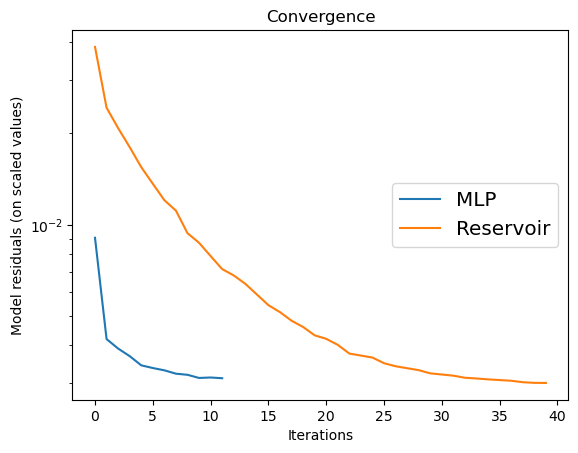

In [17]:
from matplotlib.pyplot import subplots
fig, ax = subplots()


ax.plot(results_mlp, label='MLP')
ax.plot(results_rpy, label='Reservoir')
ax.legend(loc='center right', fontsize='x-large')
ax.set_yscale('log')
ax.set_title('Convergence')
ax.set_xlabel('Iterations')
ax.set_ylabel('Model residuals (on scaled values)')


# Predictions

In [34]:
lres = []
for name, model in {'MLP': mixed_ml_mlp, 'Reservoir': mixed_ml_rpy}.items():
    for subspec in [True, False]:
        y_pred_scaled = model.predict(data_test_scaled,
                                      use_subject_specific=subspec)
        y_pred_scaled = y_pred_scaled.reshape((len(y_pred_scaled), 1))
        y_pred = scaler_y.inverse_transform(y_pred_scaled)
        lres.append({"model": name, "ss": subspec, "mse": mse(data_test[Y_LABEL], y_pred)})
        
dfres = DataFrame(lres)
dfres

,model,ss,mse
0,MLP,True,1.094151
1,MLP,False,55.188202
2,Reservoir,True,1.023389
3,Reservoir,False,186.467921
